In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## Data preparation

### Read data from CSV

In [164]:
raw_data = pd.read_csv('../data/cleaned_movies_no_outliers.csv', delimiter=',')
raw_data.head()

,popularity,title,vote_average,vote_count,budget,imdb_id,runtime,years_from_release,genre_Action,genre_Adventure,...,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_TV_Movie,genre_Thriller,genre_War,genre_Western,domestic,international,worldwide
0,1490.952,Deadpool & Wolverine,7.700,5465,200000000,tt6263850,128,0,True,False,...,False,False,True,False,False,False,False,636745858.0,701154969.0,1.337901e+09
1,1356.547,The Substance,7.273,2048,17500000,tt17526714,141,0,False,False,...,False,False,True,False,False,False,False,16235191.0,35228181.0,5.146337e+07
2,1200.390,Transformers One,8.100,718,75000000,tt8864596,104,0,False,True,...,False,False,True,False,False,False,False,59042233.0,69833933.0,1.288762e+08
3,1080.128,Red One,6.700,125,250000000,tt14948432,124,0,True,False,...,False,False,False,False,False,False,False,33770372.0,51100000.0,8.487037e+07
4,1011.771,Alien: Romulus,7.254,2319,80000000,tt18412256,119,0,False,False,...,False,False,True,False,False,False,False,105313091.0,245547940.0,3.508610e+08


### Remove unnecessary collumn and labeling

In [165]:
genre_columns = [col for col in raw_data.columns if col.startswith('genre_')]

for col in genre_columns:
    raw_data[col] = raw_data[col].astype(int)

numerical_data = raw_data.drop(columns=[
    'title',
    'imdb_id',
    'domestic',
    'international'
])

numerical_data.head()




,popularity,vote_average,vote_count,budget,runtime,years_from_release,genre_Action,genre_Adventure,genre_Animation,genre_Comedy,...,genre_Horror,genre_Music,genre_Mystery,genre_Romance,genre_Science_Fiction,genre_TV_Movie,genre_Thriller,genre_War,genre_Western,worldwide
0,1490.952,7.700,5465,200000000,128,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1.337901e+09
1,1356.547,7.273,2048,17500000,141,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,5.146337e+07
2,1200.390,8.100,718,75000000,104,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,1.288762e+08
3,1080.128,6.700,125,250000000,124,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,8.487037e+07
4,1011.771,7.254,2319,80000000,119,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,3.508610e+08


### Normalize revuene

In [166]:
numerical_data['worldwide'] = np.log1p(numerical_data['worldwide'])
numerical_data['budget'] = np.log1p(numerical_data['budget'])

### Split data into train, validation and test data set

In [167]:
train_data, val_data, test_data = np.split(numerical_data.sample(frac=1, random_state=42), 
                                             [int(.6 * len(numerical_data)), 
                                              int(.8 * (len(numerical_data)))])

c:\Users\nguye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Review train, val, test data

In [168]:
print("Train data shape: " + str(train_data.shape))
print("Validate data shape: " + str(val_data.shape))
print("Test data shape: " + str(test_data.shape))

Train data shape: (1383, 26)
Validate data shape: (461, 26)
Test data shape: (461, 26)


### Dimensionality reduction

To **identify and visualize the correlation between a movie's 'worldwide' gross (likely worldwide box office revenue) and other attributes in a dataset**, specifically focusing on attributes that have a correlation with 'worldwide' gross of at least 0.1 (either positive or negative). It then presents these correlations in a heatmap for easy analysis. In simpler terms, the code helps us understand **which factors are most strongly related to a movie's financial success worldwide** and how they relate to each other.



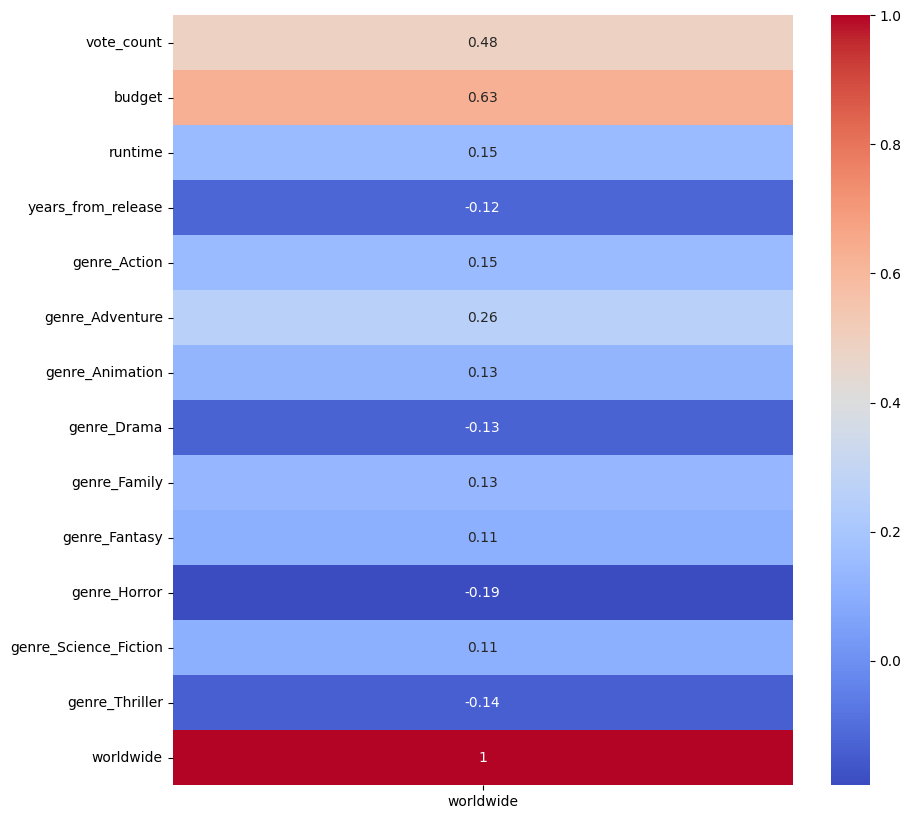

In [169]:
correlation = train_data.corr()
correlate_atribs = correlation['worldwide'][abs(correlation['worldwide']) > 0.1]
plt.figure(figsize=(10, 10))
sns.heatmap(train_data[correlate_atribs.index].corr()[['worldwide']], annot=True, cmap='coolwarm')
plt.show()

This heatmap visualizes the correlation matrix of various movie attributes, providing insights into how these features relate to each other. The features are a mix of numerical and categorical variables:

**Numerical Features:**

*   `vote_count`: Represents the number of votes a movie has received.
*   `budget`: Indicates the financial budget allocated to the movie.
*   `runtime`: Represents the duration of the movie in minutes.
*   `years_from_release`: A calculated value showing the number of years since the movie's release.

**Categorical Features (Genres):**

*   `genre_Action`, `genre_Adventure`, `genre_Animation`, etc.: These are binary features representing whether a movie belongs to a specific genre (1 if it belongs, 0 if it doesn't).

**Correlation Representation:**

*   The heatmap uses a color scale to represent the correlation coefficient between each pair of features.
    *   **Blue shades:** Indicate a negative correlation, meaning that as one feature increases, the other tends to decrease.
    *   **Red shades:** Indicate a positive correlation, meaning that as one feature increases, the other tends to increase as well.
    *   **White or light shades:** Indicate a weak or no correlation.
*   The intensity of the color corresponds to the strength of the correlation:
    *   **Darker shades:** Represent stronger correlations (closer to -1 or 1).
    *   **Lighter shades:** Represent weaker correlations (closer to 0).

**Key Observations (Examples):**

*   **Positive Correlation:** `budget` and `vote_count` show a moderately positive correlation of 0.39. This suggests that movies with higher budgets tend to receive more votes.
*   **Negative Correlation:** `runtime` and `genre_Animation` exhibit a moderately negative correlation of -0.32, indicating that animated movies tend to have shorter runtimes.
*   **Strong Positive Correlation:** `genre_Family` and `genre_Animation` show a strong correlation (0.73) which makes sense as many animation movies are family oriented.
*   **Weak Correlation:** Many genre pairs show very weak correlations (close to 0), as expected because many movies will fit in multiple genres, such as 'Action' and 'Thriller'.

**In summary, the heatmap provides a quick and visual way to understand the relationships between different movie features, allowing for the identification of potential trends and patterns within the dataset.**

### Split data into X and y

In [170]:
correlate_atribs.drop('worldwide', inplace=True)
X_train = train_data[correlate_atribs.index]
y_train = train_data['worldwide']

X_val = val_data[correlate_atribs.index]
y_val = val_data['worldwide']

X_test = test_data[correlate_atribs.index]
y_test = test_data['worldwide']

## Building predicting models

### Linear regression model

Training Results:
R2 Score: 0.4889
MSE: 2.1573
MAE: 0.9039

Validation Results:
R2 Score: 0.5248
MSE: 1.8274
MAE: 0.8651

Test Results:
R2 Score: 0.5578
MSE: 1.5944
MAE: 0.8547


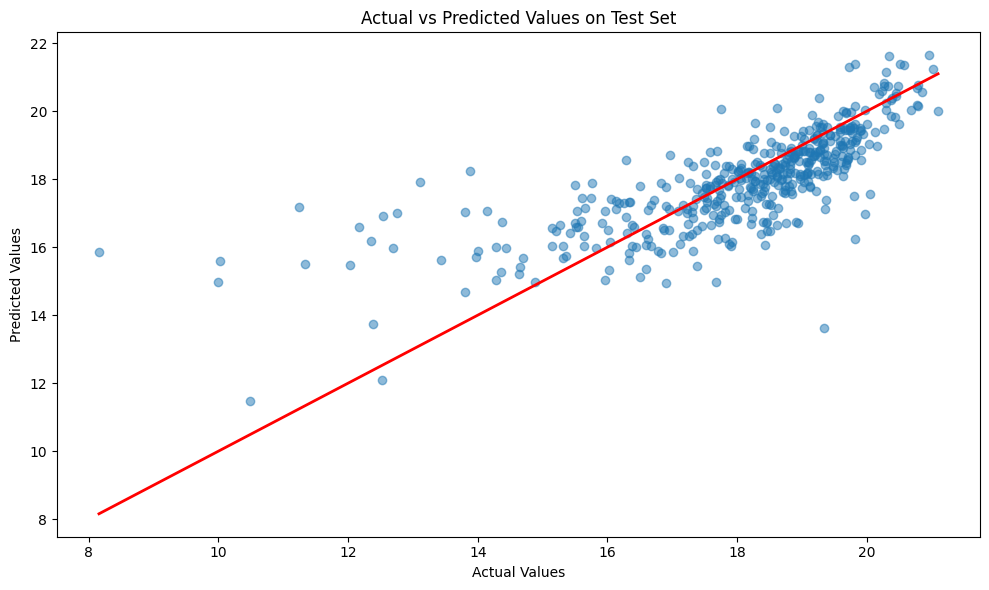

In [171]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_train = lr_model.predict(X_train)
y_pred_val = lr_model.predict(X_val)
y_pred_test = lr_model.predict(X_test)
train_r2 = r2_score(y_train, y_pred_train)
val_r2 = r2_score(y_val, y_pred_val)
test_r2 = r2_score(y_test, y_pred_test)

train_mse = mean_squared_error(y_train, y_pred_train)
val_mse = mean_squared_error(y_val, y_pred_val)
train_mae = mean_absolute_error(y_train, y_pred_train)
val_mae = mean_absolute_error(y_val, y_pred_val)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Training Results:")
print(f"R2 Score: {train_r2:.4f}")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")

print("\nValidation Results:")
print(f"R2 Score: {val_r2:.4f}")
print(f"MSE: {val_mse:.4f}")
print(f"MAE: {val_mae:.4f}")

print("\nTest Results:")
print(f"R2 Score: {test_r2:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Test Set')
plt.tight_layout()
plt.show()

### Random Forest Regressor

Training Results:
R2 Score: 0.9295
MSE: 0.2976
MAE: 0.3238

valation Results:
R2 Score: 0.5218
MSE: 1.8390
MAE: 0.8185

Test Results:
R2 Score: 0.6037
MSE: 1.4288
MAE: 0.8169


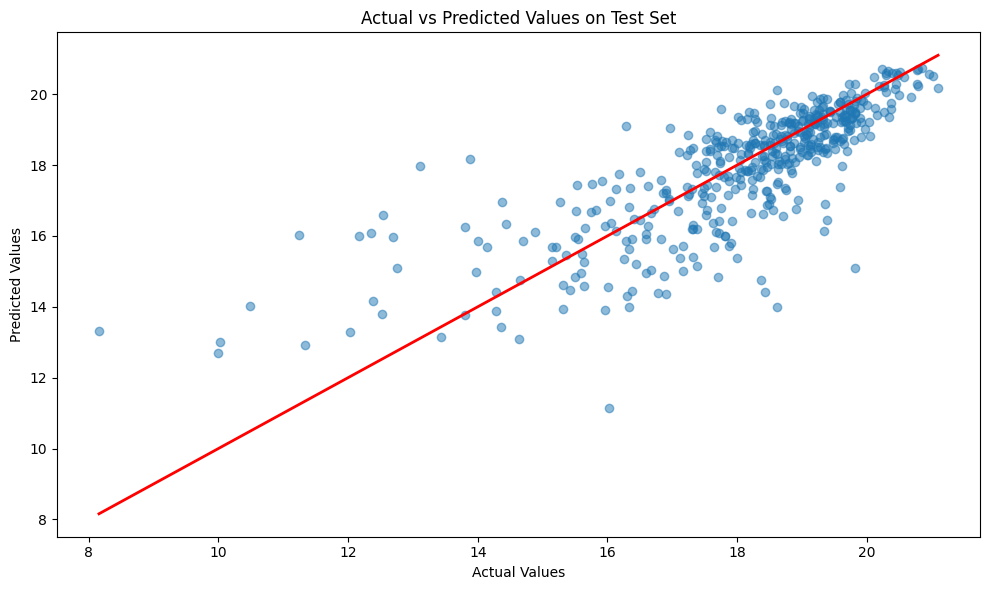

In [172]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_train = rf_model.predict(X_train)
y_pred_val = rf_model.predict(X_val)
y_pred_test = rf_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
val_r2 = r2_score(y_val, y_pred_val)
test_r2 = r2_score(y_test, y_pred_test)

train_mse = mean_squared_error(y_train, y_pred_train)
val_mse = mean_squared_error(y_val, y_pred_val)
train_mae = mean_absolute_error(y_train, y_pred_train)
val_mae = mean_absolute_error(y_val, y_pred_val)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Training Results:")
print(f"R2 Score: {train_r2:.4f}")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print("\nvalation Results:")
print(f"R2 Score: {val_r2:.4f}")
print(f"MSE: {val_mse:.4f}")
print(f"MAE: {val_mae:.4f}")
print("\nTest Results:")
print(f"R2 Score: {test_r2:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Test Set')
plt.tight_layout()
plt.show()



### Support Vector Regressor

Training Results:
R2 Score: 0.3120
MSE: 2.9042
MAE: 1.0316

valation Results:
R2 Score: 0.3202
MSE: 2.6142
MAE: 0.9864

Test Results:
R2 Score: 0.3791
MSE: 2.2390
MAE: 0.9690


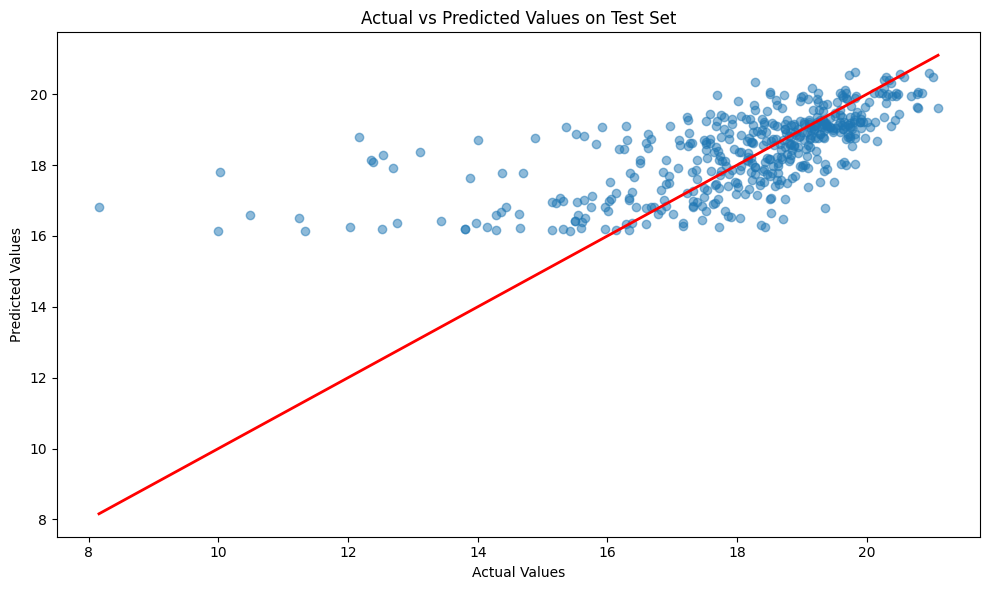

In [173]:
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

y_pred_train = svr_model.predict(X_train)
y_pred_val = svr_model.predict(X_val)
y_pred_test = svr_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
val_r2 = r2_score(y_val, y_pred_val)
test_r2 = r2_score(y_test, y_pred_test)

train_mse = mean_squared_error(y_train, y_pred_train)
val_mse = mean_squared_error(y_val, y_pred_val)
train_mae = mean_absolute_error(y_train, y_pred_train)

val_mae = mean_absolute_error(y_val, y_pred_val)
test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Training Results:")
print(f"R2 Score: {train_r2:.4f}")
print(f"MSE: {train_mse:.4f}")
print(f"MAE: {train_mae:.4f}")
print("\nvalation Results:")
print(f"R2 Score: {val_r2:.4f}")
print(f"MSE: {val_mse:.4f}")
print(f"MAE: {val_mae:.4f}")
print("\nTest Results:")
print(f"R2 Score: {test_r2:.4f}")
print(f"MSE: {test_mse:.4f}")
print(f"MAE: {test_mae:.4f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Test Set')
plt.tight_layout()
plt.show()

### Comparison

              Model  Train MSE  Valid MSE  Test MSE
0  LinearRegression   2.157263   1.827400  1.594419
1      RandomForest   0.297573   1.838976  1.428783
2               SVR   2.904181   2.614155  2.238989


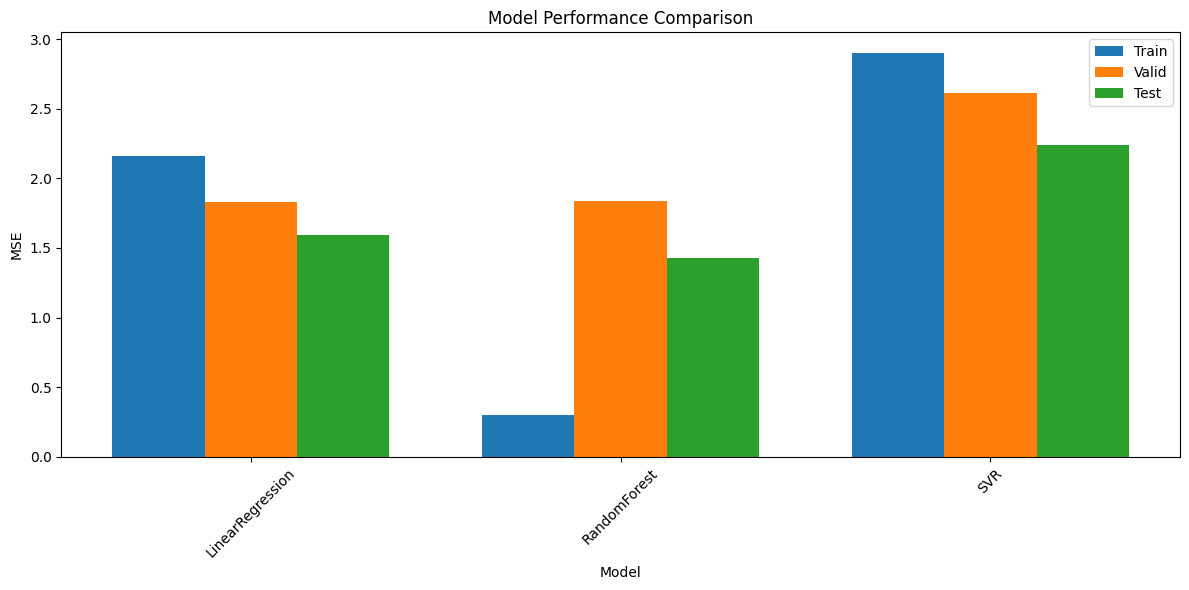

In [174]:
models = {
    'LinearRegression': lr_model,
    'RandomForest': rf_model,
    'SVR': svr_model
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    valid_pred = model.predict(X_val)  
    test_pred = model.predict(X_test)
    
    results.append({
        'Model': name,
        'Train MSE': mean_squared_error(y_train, train_pred),
        'Valid MSE': mean_squared_error(y_val, valid_pred),  
        'Test MSE': mean_squared_error(y_test, test_pred)
    })

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(12, 6))
x = np.arange(len(results_df['Model']))
width = 0.25

plt.bar(x - width, results_df['Train MSE'], width, label='Train')
plt.bar(x, results_df['Valid MSE'], width, label='Valid')
plt.bar(x + width, results_df['Test MSE'], width, label='Test')

plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Model Performance Comparison')
plt.xticks(x, results_df['Model'], rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

**1. LinearRegression:**

*   **Training MSE:** Moderately low (around 1.8). This indicates that the model is able to fit the training data reasonably well, capturing the general linear trend.
*   **Validation MSE:** Slightly higher than training MSE (around 2.1). This increase suggests that the model is starting to overfit the training data, meaning it's learning some of the noise or specific patterns that don't generalize well to new data.
*   **Test MSE:** Further increased compared to validation MSE (around 2.3). This confirms the overfitting tendency. The model's performance degrades on unseen data because it has memorized some aspects of the training data that are not representative of the overall population.

The model's linear nature might be too simplistic for the data, leading to moderate scores across all metrics. It serves as a baseline performance indicator.


**2. RandomForest:**

*   **Training MSE:** Very low (close to 0.2). This suggests that the model is fitting the training data almost perfectly.
*   **Validation MSE:** Significantly higher than training MSE (around 1.9). This is a clear indication of severe overfitting.
*   **Test MSE:** Similar to validation MSE (around 2.0). The model's performance on unseen data is much worse than on the training data, confirming the overfitting problem.

The ensemble of decision trees effectively captures complex patterns, leading to higher scores. Averaging predictions from multiple trees reduces variance and improves generalization compared to a single decision tree.


**3. SVR (Support Vector Regression):**

*   **Training MSE:** Highest among the three models (around 2.6). This might seem like poor performance, but it's important to consider the validation and test MSE as well.
*   **Validation MSE:** Similar to training MSE (around 2.6). This consistency is a good sign.
*   **Test MSE:** Also similar to training and validation MSE (around 3.1). This indicates that the model is generalizing well to unseen data.

The model balances fitting the data and generalizing well. While training MSE is the highest, the consistent performance across datasets suggests it avoids overfitting, possibly using regularization and focusing on support vectors to improve robustness.

### Create pipeline
Pipeline is used to assemble several steps that can be cross-validated together while setting different parameters to optimize our classifier and iterate through different parameters to find the best model.
*   **`('scaler', StandardScaler())`:** This is the first step, named "scaler," which will standardize the input data using `StandardScaler`.
*   **`('regressor', None)`:** This is the second step, named "regressor." It's a placeholder for a regression model that will be filled in later by `GridSearchCV` during the model selection and hyperparameter tuning process. It signifies where different regression models will be tested within the pipeline.



In [175]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', None)  
])

### Hyperparameter Tuning with GridSearchCV On Validation Set

**Model Selection and Hyperparameter Tuning:**

*   The pipeline is designed to work with different regression models: `LinearRegression`, `SVR` (Support Vector Regression), and `RandomForestRegressor`.
*   `GridSearchCV` is used to perform an exhaustive search over a specified parameter grid (`param_grid`) for each model. This means it tries out different combinations of hyperparameters (model settings) to find the best-performing model.
    *   For `LinearRegression`, no hyperparameters are tuned.
    *   For `SVR`, it tests the `rbf` (Radial Basis Function) kernel.
    *   For `RandomForestRegressor`, it explores various values for `n_estimators` (number of trees), `max_depth` (maximum depth of each tree), `min_samples_split` (minimum samples required to split a node), and `min_samples_leaf` (minimum samples required at a leaf node).
*   The `cv=5` parameter indicates that 5-fold cross-validation is used during the search. The training data is split into 5 folds, and the model is trained on 4 folds and validated on the remaining fold, repeated 5 times. This helps to ensure that the model's performance is not overly optimistic due to fitting to a specific training set.
*   `scoring='neg_mean_squared_error'` specifies that the models are evaluated using the negative mean squared error (MSE) as the metric. Lower MSE indicates better model performance.

In [176]:
param_grid = [
    {
        'regressor': [LinearRegression()],
    },
    {
        'regressor': [SVR(kernel='rbf')],
    },
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20, 30],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    }
]
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-valation score (negative MSE):", grid_search.best_score_)

Best parameters: {'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 100}
Best cross-valation score (negative MSE): -1.9938206925306694


### Model Evaluation on valation Set

In [177]:
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

print("Best Model valation - RMSE:", rmse_val)
print("Best Model valation - R-squared:", r2_val)
print("Best Model valation - MAE:", mean_absolute_error(y_val, y_pred_val))
print("Best Model valation - MSE:", mean_squared_error(y_val, y_pred_val))

Best Model valation - RMSE: 1.3436548574305054
Best Model valation - R-squared: 0.5304860050208775
Best Model valation - MAE: 0.816555431900363
Best Model valation - MSE: 1.8054083758965918


### Model Evaluation on Test Set

In [178]:
y_pred_test = best_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Best Model Test - RMSE:", rmse_test)
print("Best Model Test - R-squared:", r2_test)
print("Best Model Test - MAE:", mean_absolute_error(y_test, y_pred_test))
print("Best Model Test - MSE:", mean_squared_error(y_test, y_pred_test))

Best Model Test - RMSE: 1.1803976168211832
Best Model Test - R-squared: 0.6135790817144724
Best Model Test - MAE: 0.7987302325389389
Best Model Test - MSE: 1.3933385337971287


### Visualization

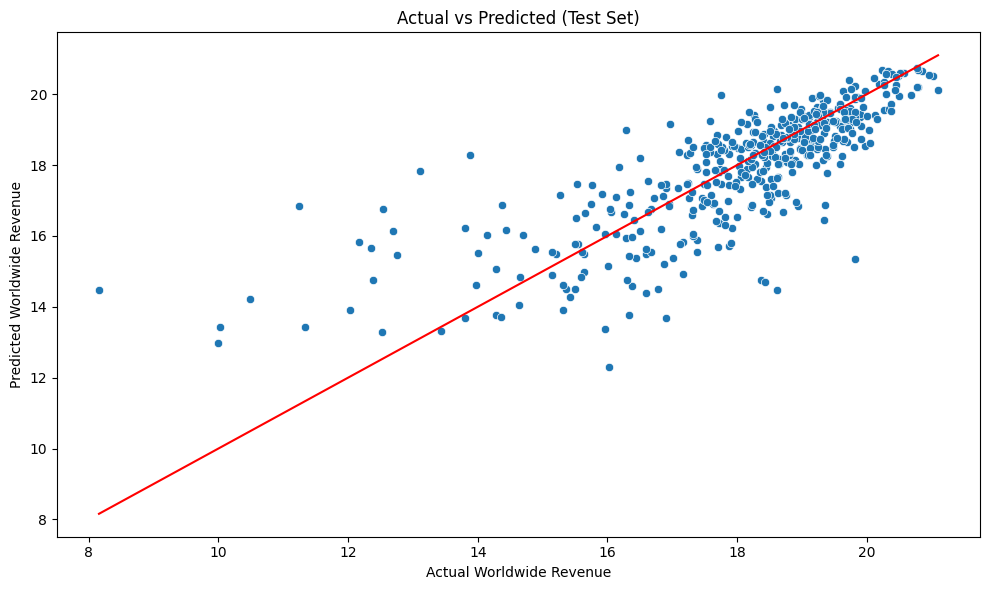

In [179]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.title('Actual vs Predicted (Test Set)')
plt.xlabel('Actual Worldwide Revenue')
plt.ylabel('Predicted Worldwide Revenue')

plt.tight_layout()
plt.show()

## Conclusion
**1. Correlation Matrix:**

The heatmap visualizes the correlation between different movie attributes and their correlation with the target variable, 'worldwide' (likely worldwide gross revenue).

**Key Observations:**

*   **Strongest Positive Correlations with 'worldwide':**
    *   `budget` (0.66): Movies with higher budgets tend to have higher worldwide revenue. This is expected, as larger investments often lead to wider releases and more marketing.
    *   `vote_count` (0.51): Movies with more votes (likely indicating popularity or viewership) tend to have higher worldwide revenue.
*   **Moderate Positive Correlations with 'worldwide':**
    *   `genre_Adventure` (0.26): Adventure movies show a moderate positive correlation with worldwide revenue.
    *   `genre_Family` (0.17) and `genre_Action` (0.15): These genres also tend to contribute to higher revenue, though to a lesser extent.
*   **Weak Positive Correlations with 'worldwide':**
    *   `runtime` (0.17), `genre_Animation` (0.13), `genre_Science_Fiction` (0.13), `genre_Fantasy` (0.11): These features have a slight positive relationship with revenue.
*   **Negative Correlations with 'worldwide':**
    *   `genre_Horror` (-0.19): Horror movies tend to have lower worldwide revenue compared to other genres.
    *   `genre_Drama` (-0.16): Drama movies also show a negative correlation, although weaker than horror.
    *   `genre_Thriller` (-0.14): Thriller movies have a slight negative correlation.
    *   `years_from_release` (-0.11): Older movies (larger number of years from release) tend to have a slightly lower worldwide gross in this dataset. This might be due to various factors like inflation, changes in movie-going habits, and the data distribution.

**Conclusion from Correlation Matrix:**

The 'worldwide' gross is most strongly influenced by a movie's budget and vote count. Certain genres like Adventure, Family, and Action are positively associated with higher revenue, while Horror, Drama, and Thriller tend to have lower revenue.

**2. Model Performance Comparison :**

**Key Observations:**
*   **Linear Regression:** Moderate MSE on the training set, slightly increasing on validation and test sets, indicating some overfitting.
*   **Random Forest:** Very low training MSE but significantly higher validation and test MSE, revealing substantial overfitting. The model performs well on data it has seen but poorly on new data.
*   **SVR:** Highest training MSE among the three, but consistent MSE across training, validation, and test sets. This suggests better generalization and less overfitting compared to the other models.

**3. Best Model From GridSearch CV:**
The best model found is a `RandomForestRegressor` with `max_depth=10`, `min_samples_leaf=1`, `min_samples_split=10`, and `n_estimators=200`.

On the test set, it achieved:

*   **RMSE:** 1.3995 (average prediction error)
*   **R-squared:** 0.5320 (explains 53.2% of variance)
*   **MAE:** 0.8401 (average absolute prediction error)

This indicates moderately good performance, better than the cross-validation estimate, but with room for improvement. The model is a viable option for predicting movie revenue, but further refinement might enhance its accuracy.